Beer3 Positive Results
==============

1. LDA
-------

In [2]:
from lda_for_fragments import run_lda
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

We set K=100 (arbitrarily) and collect 1000 samples during Gibbs sampling.

In [3]:
n_topics = 100
n_samples = 500

Then .. For each document (i.e. parent peak), we have the following bag-of-words of features:
1. The discretised m/z value of its fragment peaks. For the value, we use the the logged intensity of the fragment peak, scaled from 0..100.
2. The discretised m/z value of neutral losses. For the value, we use the log intensity of the neutral loss peak, scaled from 0..100.
3. The discretised m/z differences between each pair of fragment peaks. For the value, we use the count of occurences of such m/z differences (e.g. 1, 2, 3), scaled from 0..100.

A lot of heuristics (thresholding, etc). were used when extracting these features from the mzXML files. See extractFeatures.R for more details.

The discretisation step we use to prerocess the input before passing it to the model seems quite dodgy now. We see in the histogram below the tall bars at bin=10, 20 and 30. These come from (3) above. The rest of the histogram bins come from (1) and (2).

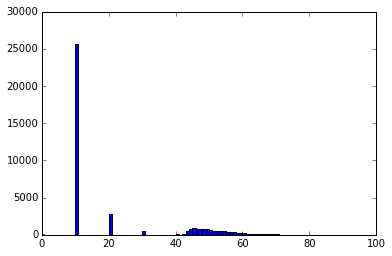

bin=0 count=0.0
bin=1 count=0.0
bin=2 count=0.0
bin=3 count=0.0
bin=4 count=0.0
bin=5 count=0.0
bin=6 count=0.0
bin=7 count=0.0
bin=8 count=0.0
bin=9 count=0.0
bin=10 count=25649.0
bin=11 count=0.0
bin=12 count=0.0
bin=13 count=0.0
bin=14 count=0.0
bin=15 count=0.0
bin=16 count=0.0
bin=17 count=0.0
bin=18 count=0.0
bin=19 count=0.0
bin=20 count=2771.0
bin=21 count=0.0
bin=22 count=0.0
bin=23 count=0.0
bin=24 count=0.0
bin=25 count=0.0
bin=26 count=0.0
bin=27 count=0.0
bin=28 count=0.0
bin=29 count=0.0
bin=30 count=554.0
bin=31 count=0.0
bin=32 count=0.0
bin=33 count=0.0
bin=34 count=0.0
bin=35 count=0.0
bin=36 count=0.0
bin=37 count=0.0
bin=38 count=0.0
bin=39 count=0.0
bin=40 count=135.0
bin=41 count=0.0
bin=42 count=109.0
bin=43 count=554.0
bin=44 count=829.0
bin=45 count=882.0
bin=46 count=804.0
bin=47 count=821.0
bin=48 count=802.0
bin=49 count=753.0
bin=50 count=656.0
bin=51 count=555.0
bin=52 count=474.0
bin=53 count=455.0
bin=54 count=461.0
bin=55 count=412.0
bin=56 count=334.0


In [4]:
data, model, topicdf, docdf = run_lda('beer3_pos', 
                         'input/Beer_3_T10_POS_fragments.csv', 
                         'input/Beer_3_T10_POS_losses.csv', 
                         'input/Beer_3_T10_POS_mzdiffs.csv', 
                         n_topics, n_samples)

LDA results can be found in the three files generated above.

2. PCA
-------

Here we use PCA to project the topics to lower-dimensional space for visualisation purposes. First ensure the variables are scaled.

In [5]:
from sklearn import preprocessing
df = docdf
print df.shape
scaled_mat = preprocessing.scale(df, axis=0)
# print scaled_mat.mean(axis=0)
# print scaled_mat.std(axis=0)

(100, 856)


Then run PCA

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(scaled_mat)
X_r = pca.transform(scaled_mat)

But the explained variances by the first two principal components are too low ..??

In [7]:
print X_r.shape
print('explained variance by the first two principal components: %s' % str(pca.explained_variance_ratio_))

(100, 2)
explained variance by the first two principal components: [ 0.03733468  0.0317454 ]


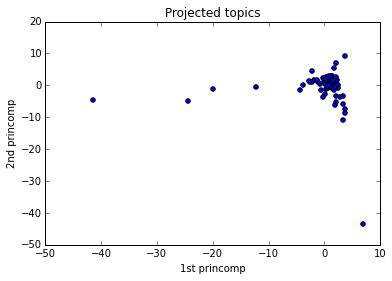

In [8]:
plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1])
plt.xlabel('1st princomp')
plt.ylabel('2nd princomp')
plt.title('Projected topics')

3. Network
------------

We can try to put the topics on a network too.

In [9]:
print df.shape
scaled_mat = preprocessing.scale(df, axis=1)
# print scaled_mat.mean(axis=1)
# print scaled_mat.std(axis=1)

(100, 856)


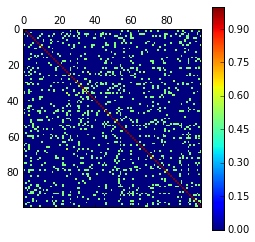

In [10]:
# create adjacency matrix A

# first compute cosine distance between the topics
from scipy.spatial.distance import cdist
A = cdist(scaled_mat, scaled_mat, 'cosine')

# crudely convert to similarity scores
A = 1/(A+1)

# set a threshold of 0.5 for the similarity values
for i in xrange(A.shape[0]):
    for j in xrange(A.shape[1]):
        if A[i, j] < 0.5:
            A[i, j] = 0

plt.matshow(A)
plt.colorbar()
plt.show()

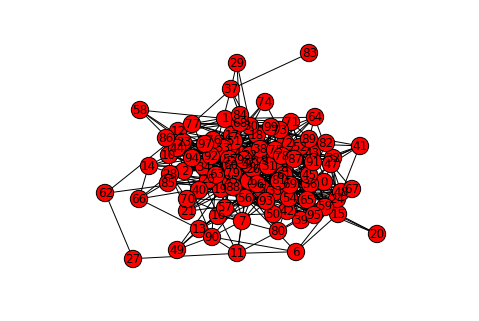

In [13]:
import networkx as nx
from networkx.readwrite import json_graph
dt = [('len', float)]
A = A.view(dt)
G = nx.from_numpy_matrix(A)
nx.draw_spring(G)

Nothing to see here? Maybe can try to run with a better layout or some community detection algorithm on the graph, or probably can make the above network interactive so we can click & drag etc to reveal some structures there.

4. Topics
---------

For every topic, we want to plot its top few parent (document) and fragment (words) peaks inside.

In [16]:
topic_fragments = model.topic_word_
for i, topic_dist in enumerate(topic_fragments):
    print "Topic " + str(i)
    column_values = np.array(data.columns.values)
    idx = np.argsort(topic_dist)[::-1] # get the indices from argsort, then reverse it using [::-1]
    topic_w = column_values[idx]
    topic_p = topic_dist[idx]
    results_all = []
    results_plot = []
    for w, p in zip(topic_w, topic_p):
        if p > 0.0001:
            results_all.append((w, p))
            if w.startswith('fragment'):
                results_plot.append((w, p))
    print results_plot
    break

Topic 0
[('fragment_53.03889', 0.025024306680863473), ('fragment_105.03345', 0.023701494116789814), ('fragment_56.96508', 0.020725165847624079), ('fragment_81.03337', 0.017528368817779399), ('fragment_127.0387', 0.016866962535742568), ('fragment_162.0756', 0.014992978069971548), ('fragment_60.04476', 0.012678056082842643), ('fragment_99.04366', 0.012457587322163699), ('fragment_134.01288', 0.012347352941824229), ('fragment_84.04422', 0.011134774758090039), ('fragment_72.04465', 0.010032430954695321), ('fragment_116.00241', 0.0095914934333374349), ('fragment_57.03369', 0.0093710246726584918), ('fragment_101.02309', 0.006615165164171698), ('fragment_91.03921', 0.0056230557411164521), ('fragment_73.02851', 0.005182118219758565), ('fragment_71.01246', 0.0050718838394190934)]
